Select one of the challenge areas below, which represent real challenges you will encounter as a data scientist in Marketplace. Use the datasets provided to you to create a technical document or presentation in which you will:

- Show and Explain the **prevalence of the problem** using the provided dataset.
- Develop **predictive model(s)** to solve the problem and evaluate the model performance.
- Discuss **metrics** that can be used to measure the business impact of your solution.
- Explain your **plan for testing** the solution and quantifying the business impact.
- **Recommend actionable next steps** and other factors to consider as we plan to solve the problem.


#### When to drive
New drivers might have trouble earning money when they join because they don’t know when and where to drive to maximize their earnings.<br> If drivers drove in **better locations and times**, Uber and driver partners would **earn more money**, and riders would get **shorter ETA’s and lower prices.**<br> Build models to predict the benefit of driving in different times and locations in the coming week, and give each driver in the dataset a recommendation about when and where to drive. Please be explicit about what you’re optimizing for and why.


normalized scalar
feature_mapper
pca

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from scipy.stats import norm, boxcox, skewnorm, percentileofscore

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.tree import DecisionTreeRegressor

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df1 = pd.read_excel('uber_exer.xlsx', sheet_name=0)
df1 = df1.drop('Unnamed: 0', axis=1)

In [8]:
df1.rename(columns={'Data Overview':'Data', 'Unnamed: 2':'Overview'}, inplace=True)

In [9]:
pd.set_option('display.max_colwidth', -1)
df1

,Data,Overview
0,"The data in these tables represent a portion of the total data for the city. For example, trip data only includes trips within the city that start or end within given geofences, so there are more total trips in the city.\n\nSimilarly, the driver and rider data tables represent only a portion of drivers and riders in the city.\n\nLast, there may be some data that is incorrect or missing. Feel free to call this out in your analysis.",NaN
1,NaN,NaN
2,driver_trips,NaN
3,trip_id,Unique identifier for trip
4,driver_id,Unique identifier for driver
5,trip_status,"Status of the trip \n(unfulfilled = rider request, no driver able to dispatch\nfailed = trip request failed)"
6,actual_time_to_arrival,Minutes from request to pick-up
7,request_time,Local request time of the trip
8,surge_multiplier,The surge multiplier of the request (1 is no surge)
9,driver_payout,The amount the driver was paid for the trip


In [96]:
driver_trips = pd.read_excel('uber_exer.xlsx', sheet_name=1)
rider_trips = pd.read_excel('uber_exer.xlsx', sheet_name=2)
driver_data = pd.read_excel('uber_exer.xlsx', sheet_name=3)
rider_data = pd.read_excel('uber_exer.xlsx', sheet_name=4)
city_metrics = pd.read_excel('uber_exer.xlsx', sheet_name=5)

In [97]:
dd_cols = list(driver_data.columns.difference(driver_trips.columns))
dd_cols = ['driver_id'] + dd_cols

cdnsd = driver_trips.merge(driver_data[dd_cols], on='driver_id')

In [98]:
rt_cols = list(rider_trips.columns.difference(cdnsd.columns))
rt_cols = ['trip_id'] + rt_cols

cdnsd = cdnsd.merge(rider_trips[rt_cols], on='trip_id')

In [99]:
rd_cols = list(rider_data.columns.difference(cdnsd.columns))
rd_cols = ['rider_id'] + rd_cols

cdnsd = cdnsd.merge(rider_data[rd_cols], on='rider_id')

In [100]:
cdnsd['timestamp'] = cdnsd['request_time'].dt.floor('h')

In [101]:
cm_cols = list(city_metrics.columns.difference(cdnsd.columns))
cm_cols = ['timestamp'] + cm_cols

cdnsd = cdnsd.merge(city_metrics[cm_cols], on='timestamp')

In [102]:
rider = list(set(a for a in cdnsd['rider_id']))
driver = list(set(a for a in cdnsd['driver_id']))

In [103]:
riders = {}
drivers = {}

In [104]:
for i, r in enumerate(rider, 1):
    riders[r] = i

In [105]:
for i, r in enumerate(driver, 1):
    drivers[r] = i

In [106]:
cdnsd['rider'] = cdnsd.copy()['rider_id'].apply(lambda x: riders[x] if x in riders else 0)

In [107]:
cdnsd['driver'] = cdnsd.copy()['driver_id'].apply(lambda x: drivers[x] if x in drivers else 0)

In [108]:
original_col = list(cdnsd.columns.drop(['driver_id', 'rider_id', 'request_time', 'trip_id', 'trip_status', 'start_geo', 'end_geo', 'first_completed_trip', 'timestamp', 'driver payout', 'rider_payment', 'trip_price_pre_discount']))

In [109]:
# some features; 
cdnsd['time'] = cdnsd['request_time'].apply(lambda x: x.hour)
cdnsd['weekday'] = cdnsd['request_time'].apply(lambda x: x.weekday())
cdnsd['month'] = cdnsd['request_time'].apply(lambda x: x.month)
cdnsd['day'] = cdnsd['timestamp'].apply(lambda x: x.day)
cdnsd['weekend'] = cdnsd['weekday'].apply(lambda x: 1 if x > 4 else 0) # count friday as a weekend?

# keep for now
a = {0:'M', 1:'Tu', 2:'We', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}
aa = ['M', 'Tu', 'We', 'Th', 'F', 'Sa', 'Su']
# cdnsd['weekday_1'] = cdnsd.copy()['weekday'].replace(a)

# cdnsd['arrival_in_mins'] = np.array(cdnsd['actual_time_to_arrival']).astype(int)
# cdnsd['pay_in_dollars'] = np.array(cdnsd['driver payout']).astype(int)

# add feature - ranked_score of driver_lifetime rating; 

# performance metrics
cdnsd['fare/trip'] = cdnsd['lifetime_fares']/cdnsd['lifetime_completed_trips']
cdnsd['arrival/eta'] =  cdnsd['estimated_time_to_arrival'] / cdnsd['actual_time_to_arrival']

cdnsd['arrive_ontime'] = cdnsd['arrival/eta'].apply(lambda x: 1 if x<=1 else 0)

In [110]:
cdnsd = cdnsd[cdnsd['trip_status']=='completed']

In [111]:
locs = list(set([a for a in cdnsd.start_geo]))
locs = sorted(locs)

In [112]:
ref = {}
for start in locs:
    for end in locs:
        r = start[0] + end[0]
        ref[r] = [start, end]

In [113]:
cdnsd['start_end'] = cdnsd[['start_geo', 'end_geo']].values.tolist()

In [114]:
for k in ref.keys():
    cdnsd[k] = cdnsd['start_end'].apply(lambda x: 1 if x==ref[k] else 0)

#### 'Chelsea Court' to 'Chelsea Court' has half the observations
- going by initials from this point forward; 
- 'Chelsea Court' to 'Chelsea Court' = 'CC'

In [115]:
destination = ['AA','AB','AC','AD','BA','BB','BC','BD','CA','CB','CC','CD','DA','DB','DC','DD']

cdnsd.loc[:, destination].sum().sort_values(ascending=False)

CC    24644
CA    5698 
AC    5566 
AA    3125 
CB    2232 
CD    2227 
DC    2182 
BC    2081 
DD    1467 
BB    1155 
AD    334  
DA    291  
BA    283  
AB    280  
DB    190  
BD    165  
dtype: int64

#### find trips where trip_price_pre_discount is different from rider_payment

In [116]:
cdnsd['discount'] = cdnsd['trip_price_pre_discount'] - cdnsd['rider_payment']

In [117]:
cdnsd['discount_trip'] = cdnsd['discount'].apply(lambda x: 1 if x!=0 else 0)

In [118]:
night = [0, 1, 2, 21, 22, 23]
morning = [3, 4, 5, 6, 7, 8]
midday = [9, 10, 11, 12, 13, 14]
evening = [15, 16, 17, 18, 19, 20]

day = {'morning':morning, 'midday':midday, 'evening':evening, 'night':night}

In [119]:
for d in day.keys():
    cdnsd[d] = cdnsd['time'].apply(lambda x: 1 if x in day[d] else 0)

In [120]:
cdnsd['surge_difference'] = cdnsd['surge_multiplier'] - cdnsd['mean_surge_multipler']

#### trips where surge is greater than mean_surge

In [121]:
cdnsd['surge_diff'] = cdnsd['surge_difference'].apply(lambda x: 1 if x >=0 else 0)

In [122]:
# mean_surge_multipler mean of entire surge (?)
cdnsd.groupby(['month', 'day', 'time']).get_group((4, 9, 6))[['request_time', 'timestamp', 'start_end', 'mean_surge_multipler']];

In [123]:
# mean of surge_multiplier - grouped by month, day, time - does not equal mean_surge_mutlipler
print(cdnsd.groupby(['month', 'day', 'time']).get_group((4, 9, 6))['surge_multiplier'].mean())
print(cdnsd.groupby(['month', 'day', 'time']).get_group((4,9,6))['mean_surge_multipler'][0])

1.4038461538461533
1.21892755681818


In [124]:
d = {}
for start in locs:
    for end in locs:
        drive = start[0] + end[0]
        d[drive] = cdnsd.groupby(['start_geo', 'end_geo']).get_group((start, end))

In [125]:
destination = ['AA','AB','AC','AD','BA','BB','BC','BD','CA','CB','CC','CD','DA','DB','DC','DD']
df = pd.DataFrame()

for i, v in enumerate(destination, 1):
    temp = cdnsd[v].apply(lambda x: i if x==1 else float('nan'))
    df = pd.concat([df, temp], axis=1)

    
cdnsd['loc'] = df.stack().values

In [126]:
day_1 = ['morning', 'midday', 'evening', 'night']
df = pd.DataFrame()

for i, v in enumerate(day_1, 1):
    temp = cdnsd[v].apply(lambda x: i if x==1 else float('nan'))
    df = pd.concat([df, temp], axis=1)
    
cdnsd['time_of_day'] = df.stack().values

In [127]:
cdnsd['avg_surge_diff'] = cdnsd.index
cdnsd.loc[:, 'avg_surge_diff'] = cdnsd.groupby(['weekday', 'time'])['surge_multiplier'].apply(lambda x: x-x.mean())

In [128]:
# metric to use
# can't use estimated time if destination changes, etc
# use 'rider_payment' instead of 'driver payout' - very high correlation, 
cdnsd['pay/time'] = cdnsd['rider_payment'] / cdnsd['actual_time_to_arrival']

In [129]:
# cdnsd['avg_pay_diff'] = cdnsd.groupby(['weekday', 'time'])['driver payout'].apply(lambda x: x-x.mean())

### Change to include trip_status, change to binomial, add to features
### feature maps

In [130]:

df = cdnsd.copy()[cdnsd['trip_price_pre_discount']<50]

In [131]:
# col_1 = ['driver payout', 'rider_payment', 'trip_price_pre_discount', 'surge_multiplier', 'mean_surge_multipler', 'lifetime_rating', 'request_time', 'estimated_time_to_arrival', 'actual_time_to_arrival','supply_hours', 'start_geo', 'end_geo']

# features (maybe add eta feature)
# col_f = ['loc', 'discount_trip', 'weekend', 'time_of_day', 'surge_diff', 'surge_multiplier',  'arrive_ontime', 'actual_time_to_arrival']
col_f = ['driver', 'lifetime_fares', 'lifetime_rating', 'rider', 'loc', 'CC', 'BD', 'DB', 'weekday', 'time', 'requests', 'actual_time_to_arrival', 'arrive_ontime', 'discount', 'avg_surge_diff']

# metric (one at a time?)
col_m = 'pay/time'

In [132]:
cdnsd.columns

Index(['trip_id', 'driver_id', 'trip_status', 'actual_time_to_arrival',
       'request_time', 'surge_multiplier', 'driver payout', 'start_geo',
       'end_geo', 'first_completed_trip', 'lifetime_completed_trips',
       'lifetime_fares', 'lifetime_rating', 'estimated_time_to_arrival',
       'rider_id', 'rider_payment', 'trip_price_pre_discount',
       'first_trip_city_id', 'lifetime_payments', 'lifetime_trips',
       'timestamp', 'mean_surge_multipler', 'requests', 'supply_hours',
       'trips', 'rider', 'driver', 'time', 'weekday', 'month', 'day',
       'weekend', 'arrival_in_mins', 'pay_in_dollars', 'fare/trip',
       'arrival/eta', 'arrive_ontime', 'start_end', 'AA', 'AB', 'AC', 'AD',
       'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'CC', 'CD', 'DA', 'DB', 'DC', 'DD',
       'discount', 'discount_trip', 'morning', 'midday', 'evening', 'night',
       'surge_difference', 'surge_diff', 'loc', 'time_of_day',
       'avg_surge_diff', 'pay/time'],
      dtype='object')

In [133]:
col_f.append(col_m)

In [134]:
test = df[col_f].dropna()

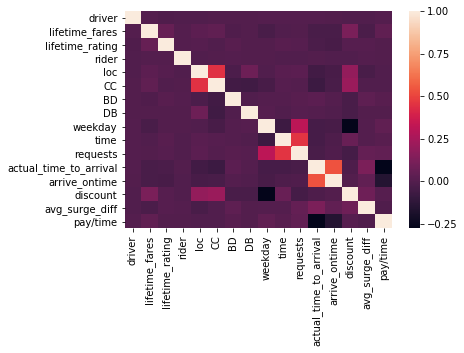

In [135]:
sns.heatmap(test.corr())

In [136]:
percentileofscore(test['pay/time'], 25)

90.3933220147142

In [137]:
test_1 = test.copy()[test['pay/time']<=25]

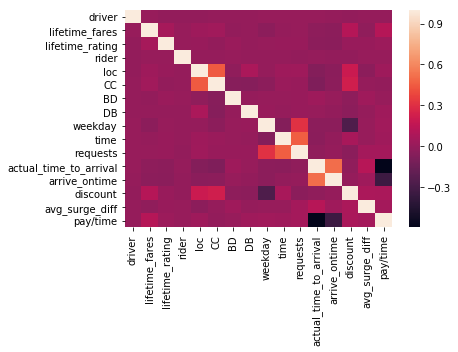

In [138]:
sns.heatmap(test_1.corr())

In [139]:
lg = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gnb = GaussianNB()

In [140]:
def regressions(df, model):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    if model == 'all':
        lg.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        rf.fit(X_train, y_train.iloc[:, 0])
        x = (X_train.shape, X_test.shape, lg.score(X_test, y_test), dt.score(X_test, y_test), rf.score(X_test, y_test))

    else:    
        model.fit(X_train, y_train.iloc[:, 0])
        x = (X_train.shape, X_test.shape, model.score(X_test, y_test))
    
    return x

In [141]:
regressions(test_1, 'all')

((33542, 15),
 (11181, 15),
 0.4052914057517386,
 0.6922687508983907,
 0.8327867153815536)

In [142]:
original_col.append(col_m)

In [143]:
df_o = df.copy()[original_col].dropna()

In [144]:
df_orig = df_o[df_o['pay/time']<=25]

In [145]:
regressions(df_orig, 'all')

((33524, 15),
 (11175, 15),
 0.4254066139063771,
 0.5746046431285449,
 0.7709324347447766)

In [146]:
X_1 = df.drop(['trip_price_pre_discount', 'start_end', 'trip_status', 'request_time', 'first_completed_trip', 'driver payout', 'rider_payment', 'pay_in_dollars', 'timestamp', 'start_geo', 'end_geo', 'trip_id', 'weekday', 'driver_id', 'rider_id'], axis=1)

In [147]:
X_1.dropna(inplace=True)

In [148]:
X_1 = X_1[X_1['pay/time']<=20]

In [149]:
X_2 = X_1.drop(original_col, axis=1)

In [150]:
X_2['driver'] = X_1.copy()['driver']
X_2['rider'] = X_1.copy()['rider']
X_2['pay/time'] = X_1.copy()['pay/time']

In [151]:
# "X1" contains all features/variables that can be used
regressions(X_1, 'all')

((33116, 50),
 (11039, 50),
 0.6810040250800331,
 0.731347178289629,
 0.8481161298446612)

In [152]:
X_1.columns

Index(['actual_time_to_arrival', 'surge_multiplier',
       'lifetime_completed_trips', 'lifetime_fares', 'lifetime_rating',
       'estimated_time_to_arrival', 'first_trip_city_id', 'lifetime_payments',
       'lifetime_trips', 'mean_surge_multipler', 'requests', 'supply_hours',
       'trips', 'rider', 'driver', 'time', 'month', 'day', 'weekend',
       'arrival_in_mins', 'fare/trip', 'arrival/eta', 'arrive_ontime', 'AA',
       'AB', 'AC', 'AD', 'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'CC', 'CD', 'DA',
       'DB', 'DC', 'DD', 'discount', 'discount_trip', 'morning', 'midday',
       'evening', 'night', 'surge_difference', 'surge_diff', 'loc',
       'time_of_day', 'avg_surge_diff', 'pay/time'],
      dtype='object')

In [153]:
# "X2" = "X1" - "original_col" ( + variables/features that are needed)
regressions(X_2, 'all')

((33116, 37),
 (11039, 37),
 0.5690549008957213,
 0.6339335840330271,
 0.7928846244153653)

In [154]:
X_2.columns

Index(['time', 'month', 'day', 'weekend', 'arrival_in_mins', 'fare/trip',
       'arrival/eta', 'arrive_ontime', 'AA', 'AB', 'AC', 'AD', 'BA', 'BB',
       'BC', 'BD', 'CA', 'CB', 'CC', 'CD', 'DA', 'DB', 'DC', 'DD', 'discount',
       'discount_trip', 'morning', 'midday', 'evening', 'night',
       'surge_difference', 'surge_diff', 'loc', 'time_of_day',
       'avg_surge_diff', 'driver', 'rider', 'pay/time'],
      dtype='object')

In [67]:
# X_11 = X_1.iloc[:, :-1]
# y_11 = X_1.iloc[:, -1:]

X_11 = test_1.iloc[:, :-1]
y_11 = test_1.iloc[:, -1:]

In [68]:
yyy = np.asarray(y_11['pay/time'], dtype="|S6")

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_11, yyy)


In [70]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [71]:
gnb.score(X_test, y_test)

0.0008049369466058492

##### am i supposed to groupby the highest 'pay/time' (except for the outliers)

In [72]:
df.columns

Index(['trip_id', 'driver_id', 'trip_status', 'actual_time_to_arrival',
       'request_time', 'surge_multiplier', 'driver payout', 'start_geo',
       'end_geo', 'first_completed_trip', 'lifetime_completed_trips',
       'lifetime_fares', 'lifetime_rating', 'estimated_time_to_arrival',
       'rider_id', 'rider_payment', 'trip_price_pre_discount',
       'first_trip_city_id', 'lifetime_payments', 'lifetime_trips',
       'timestamp', 'mean_surge_multipler', 'requests', 'supply_hours',
       'trips', 'rider', 'driver', 'time', 'weekday', 'month', 'day',
       'weekend', 'arrival_in_mins', 'pay_in_dollars', 'fare/trip',
       'arrival/eta', 'arrive_ontime', 'start_end', 'AA', 'AB', 'AC', 'AD',
       'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'CC', 'CD', 'DA', 'DB', 'DC', 'DD',
       'discount', 'discount_trip', 'morning', 'midday', 'evening', 'night',
       'surge_difference', 'surge_diff', 'loc', 'time_of_day',
       'avg_surge_diff', 'pay/time', 'avg_pay_diff'],
      dtype='object')

In [73]:
col_n_f = ['driver', 'rider', 'pay/time', 'surge_multiplier', 'requests', 'estimated_time_to_arrival', 'rider_payment', 'time', 'weekday', 'CC', 'BD', 'DB']
col_n_m = 'loc'

In [74]:
col_n_f.append(col_n_m)

In [75]:
df_n = df[col_n_f].dropna()

In [76]:
df_n = df_n[df_n['pay/time']<=25]

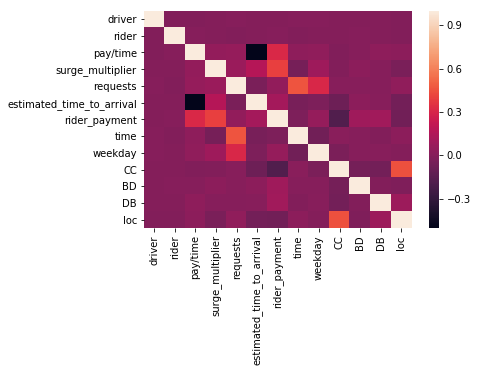

In [77]:
sns.heatmap(df_n.corr())

In [78]:
bnb = BernoulliNB()

In [79]:
regressions(df_n, bnb)

((33569, 12), (11190, 12), 0.5970509383378017)

In [80]:
gnb_pf = GaussianNB()

In [81]:
def price_mapper(price):
    if price < 5:
        return 1
    elif price < 10:
        return 2
    elif price < 15:
        return 3
    elif price < 20:
        return 4
    else:
        return 5

In [82]:
cdnsd['price_bin'] = cdnsd['trip_price_pre_discount'].apply(lambda x: price_mapper(x))

In [83]:
cdnsd.groupby('price_bin')['surge_multiplier'].mean()

price_bin
1    1.080016
2    1.111983
3    1.351200
4    1.402783
5    1.268695
Name: surge_multiplier, dtype: float64

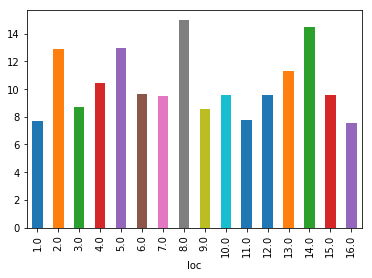

In [84]:
cdnsd.groupby('loc')['trip_price_pre_discount'].mean().plot(kind='bar')

In [85]:
cdnsd.groupby('arrive_ontime')['trip_price_pre_discount'].mean()

arrive_ontime
0    8.629727
1    7.810235
Name: trip_price_pre_discount, dtype: float64

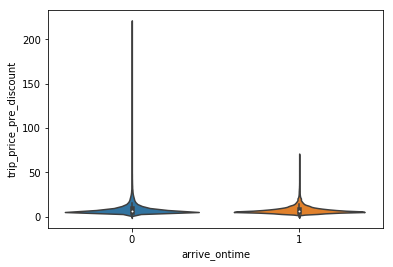

In [86]:
sns.violinplot(x='arrive_ontime', y='trip_price_pre_discount', data=cdnsd)

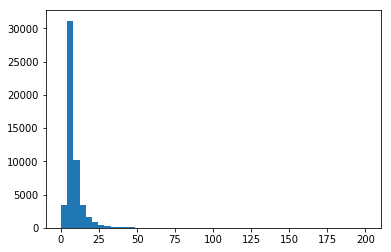

In [87]:
plt.hist(cdnsd['trip_price_pre_discount'], bins=np.linspace(0, 200, 50))
plt.show()

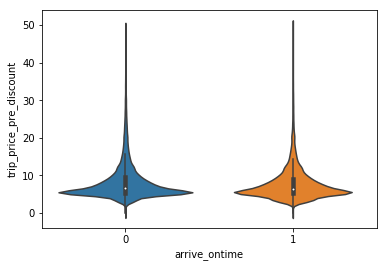

In [88]:
sns.violinplot(x='arrive_ontime', y='trip_price_pre_discount', data=df)

In [89]:
df.groupby('arrive_ontime')['trip_price_pre_discount'].mean()

arrive_ontime
0    8.479850
1    7.797862
Name: trip_price_pre_discount, dtype: float64

In [90]:
df.groupby('arrive_ontime')['trip_price_pre_discount'].mean()

arrive_ontime
0    8.479850
1    7.797862
Name: trip_price_pre_discount, dtype: float64

In [91]:
col2 = ['actual_time_to_arrival', 'arrive_ontime', 'surge_diff']

X_0 = df[['loc','surge_multiplier', 'surge_diff', 'arrive_ontime', 'actual_time_to_arrival']]
y_0 = df.trip_price_pre_discount

In [92]:
abs(y_predict - y_test).mean()

NameError: name 'y_predict' is not defined

In [ ]:
# plt.scatter(y_test, y_predict-y_test)

#### average price per location

In [ ]:
gnb = GaussianNB()

In [ ]:
sns.set()

g = sns.FacetGrid(city_metrics, col='weekday', size=7, aspect=1, col_wrap=3)
g.map(sns.pointplot, 'time', 'mean_surge_multipler')

In [ ]:
driver_payout = cdnsd.groupby(['weekday', 'time'])['driver payout'].mean()

In [ ]:
driver_payout = driver_payout.unstack(level=0)[aa]

In [ ]:
sns.heatmap(driver_payout)

# group this one with eta

In [ ]:
cdnsd.groupby(['start_geo', 'end_geo'])['estimated_time_to_arrival'].mean()

In [ ]:
city_surge = city_metrics.groupby(['weekday', 'time'])['mean_surge_multipler'].mean()
city_req = city_metrics.groupby(['weekday', 'time'])['requests'].mean()
city_trips = city_metrics.groupby(['weekday', 'time'])['trips'].mean()
city_supply = city_metrics.groupby(['weekday', 'time'])['supply_hours'].mean()

In [ ]:
city_surge = city_surge.unstack(level=0)[aa]
city_req = city_req.unstack(level=0)[aa]
city_trips = city_trips.unstack(level=0)[aa]
city_supply = city_supply.unstack(level=0)[aa]

In [ ]:
sns.heatmap(city_surge * city_supply)

First, the **"outlier" on 'Th' at 8** may be causing higher percentage of neutral colors (below)

In [ ]:
sns.heatmap(city_surge)

In [ ]:
sns.heatmap(city_supply)

### question is about new drivers
### better locations and times (assuming when mean surge multiplier is high)

### in city_metrics, i have mean_surge_mult by the hour...

***


# when grouping up by variables, A/A test each 
## do this in case of unexpected or seasonal events (outliers)
### actually a big difference between an unexpected event and a seasonal event
### skirt around for now


## find mean of 'surge_multiplier' in driver_trips

In [ ]:
tips = sns.load_dataset("tips")

In [ ]:
g = sns.factorplot(x='end_geo', y='driver payout', col='start_geo', data=cdnsd, kind='bar', size=4, aspect=.7)

In [ ]:
g = sns.factorplot(x='end_geo', y='surge_multiplier', col='start_geo', data=cdnsd, kind='bar', size=4, aspect=.7, sharey=False)

In [ ]:
g = sns.factorplot(x='end_geo', y='estimated_time_to_arrival', col='start_geo', data=cdnsd, kind='bar', size=4, aspect=.7, sharey=False)

In [ ]:
cdnsd.groupby('start_geo')['surge_multiplier'].mean()

In [ ]:
cdnsd.groupby('start_geo')['driver payout'].mean()

In [ ]:
cdnsd.groupby('end_geo')['driver payout'].mean()

In [ ]:
cdnsd.groupby(['start_geo', 'end_geo'])['surge_multiplier'].mean()

In [ ]:
cdnsd.groupby(['start_geo', 'end_geo'])['driver payout'].mean()

In [ ]:
cdnsd.groupby(['start_geo', 'end_geo'])['estimated_time_to_arrival'].mean()

In [ ]:
X = test_1.iloc[:, :-1]
y = test_1.iloc[:, -1:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
lg.fit(X_train, y_train)

In [ ]:
lg.score(X_test, y_test)

In [ ]:
y_predict = lg.predict(X_test)

In [ ]:
dt.fit(X_train, y_train)

In [ ]:
dt.score(X_test, y_test)

In [ ]:
rf.fit(X_train, y_train.iloc[:, 0])

In [ ]:
rf.score(X_test, y_test)